In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from TABS.Models.TABS_Model import TABS

import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import os
import SimpleITK as sitk


from monai.transforms import (
    Compose,
    LoadImage,
    Spacing,
    NormalizeIntensity,
    ScaleIntensityRange,
    AdjustContrast,
    MapTransform,
    HistogramNormalize,
    CenterSpatialCrop,
    SpatialPad,
    SaveImage
)
from monai.data import Dataset, DataLoader
import matplotlib.pyplot as plt


d:\Study\M.Sc\MAIA\Musarrat\Semester_3\MISA\MISA_Project\Project_test-1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(torch.cuda.is_available())  # This should return True if a GPU is available

True


In [ ]:
training_data_path = 'Training_Set'
validation_data_path = 'Validation_Set'
output_path = 'ProcessedDataV3'

Loaded image shape: torch.Size([1, 192, 192, 192])


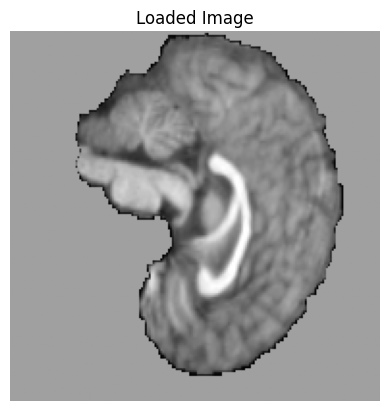

Loaded label shape: torch.Size([1, 192, 192, 192])


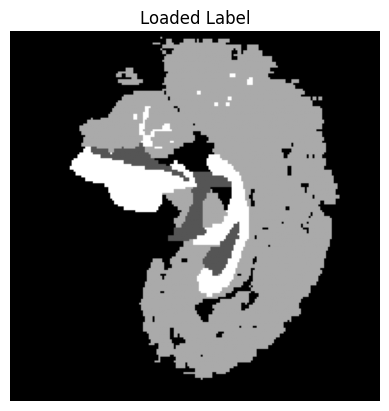

In [ ]:
# Helper function to visualize a slice of 3D image
def visualize_image(image, title="Image Slice"):
    if len(image.shape) == 3:  # If image has [D, H, W]
        slice_idx = image.shape[0] // 2  # Take the middle slice
        plt.imshow(image[slice_idx, :, :], cmap="gray")
    elif len(image.shape) == 4:  # If image has [C, D, H, W]
        slice_idx = image.shape[1] // 2  # Take the middle slice in depth
        plt.imshow(image[0, slice_idx, :, :], cmap="gray")  # Visualize first channel
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to load and check image dimensions
def load_and_visualize(image_path, label_path=None):
    # MONAI transform to load image
    loader = LoadImaged(keys=["image", "label"] if label_path else ["image"])
    data = {"image": image_path}
    if label_path:
        data["label"] = label_path

    # Load image and (optionally) label
    loaded_data = loader(data)

    # Extract image and label
    image = loaded_data["image"]
    print(f"Loaded image shape: {image.shape}")  # Check the dimensions
    visualize_image(image, title="Loaded Image")

    if label_path:
        label = loaded_data["label"]
        print(f"Loaded label shape: {label.shape}")  # Check the label dimensions
        visualize_image(label, title="Loaded Label")

    return loaded_data

# Test the function
image_path = "ProcessedDataV3/Training_Set/Image/IBSR_18_trans.nii.gz"
label_path = "ProcessedDataV3/Training_Set/Label/IBSR_18_seg_trans.nii.gz"  # Optional, set to None if not available
loaded_data = load_and_visualize(image_path, label_path)


In [ ]:
# Custom transform to add a channel dimension
class AddChannelDim(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            data[key] = data[key][None]  # Add channel dimension (axis=0)
        return data


# Image preprocessing pipeline
image_transforms = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),       # Load image with channel first
    # CenterSpatialCrop(roi_size=(192, 192, 192)),
    Spacing(pixdim=(1.0, 1.0, 1.0), mode='bilinear'),           # Resample image to isotropic spacing
    NormalizeIntensity(nonzero=True, channel_wise=True),        # Normalize intensity to standardize
    ScaleIntensityRange(a_min=-3.364, a_max=1.81, b_min=-1.0, b_max=1.0, clip=True),
    CenterSpatialCrop(roi_size=(192, 192, 192)),                # Crop to 192x192x192
    # HistogramNormalize(num_bins=256),                           # Flatten the intensity distribution
])

# Label preprocessing pipeline
label_transforms = Compose([
    LoadImage(image_only=True, ensure_channel_first=True),       # Load label
    # CenterSpatialCrop(roi_size=(192, 192, 192)),
    Spacing(pixdim=(1.0, 1.0, 1.0), mode='nearest'),            # Resample label to isotropic spacing
    CenterSpatialCrop(roi_size=(192, 192, 192)),                # Crop to 192x192x192
])


In [ ]:
# Helper function to process and save files
def preprocess_and_save(image_path, label_path, output_dir):
    # Process the image
    processed_image = image_transforms(image_path)
    processed_label = label_transforms(label_path)

    # Define output paths
    image_save_path = os.path.join(output_dir, os.path.basename(image_path))
    label_save_path = os.path.join(output_dir, os.path.basename(label_path))

    # Save the processed image and label
    SaveImage(output_dir=output_dir, separate_folder=False)(processed_image, image_save_path)
    SaveImage(output_dir=output_dir, separate_folder=False)(processed_label, label_save_path)


In [ ]:
def preprocess_and_save(image_path, label_path, output_dir_image, output_dir_label):
    """Applies preprocessing and saves the image and label to separate directories."""
    # Process the image
    processed_image = image_transforms(image_path)
    processed_label = label_transforms(label_path)

    # Save the processed image and label
    image_output_path = os.path.join(output_dir_image, os.path.basename(image_path).replace('.nii.gz', '_trans.nii.gz'))
    label_output_path = os.path.join(output_dir_label, os.path.basename(label_path).replace('.nii.gz', '_trans.nii.gz'))

    nib.save(nib.Nifti1Image(processed_image.numpy(), affine=np.eye(4)), image_output_path)
    nib.save(nib.Nifti1Image(processed_label.numpy(), affine=np.eye(4)), label_output_path)

    print(f"Saved Image: {image_output_path}")
    print(f"Saved Label: {label_output_path}")


def process_data(data_path, output_folder_name):
    """Processes data from a given path and saves it to the output directory."""
    print(f"Processing {output_folder_name} Data...")

    # Directories for saving images and labels
    output_dir_image = os.path.join(output_path, output_folder_name, "Image")
    output_dir_label = os.path.join(output_path, output_folder_name, "Label")
    os.makedirs(output_dir_image, exist_ok=True)
    os.makedirs(output_dir_label, exist_ok=True)

    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):  # Ensure it's a folder
            # Construct file paths
            image_file = os.path.join(folder_path, f"{folder}.nii.gz")
            label_file = os.path.join(folder_path, f"{folder}_seg.nii.gz")

            # Check if both image and label files exist
            if os.path.exists(image_file) and os.path.exists(label_file):
                preprocess_and_save(image_file, label_file, output_dir_image, output_dir_label)
                print(f"Processed: {folder}")
            else:
                print(f"Missing files for: {folder} (image: {image_file}, label: {label_file})")
    print(f"{output_folder_name} Data Processing Complete.\n")


# Process Training and Validation Data
process_data(training_data_path, "Training_Set")
process_data(validation_data_path, "Validation_Set")

Processing Training_Set Data...
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_01_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_01_seg_trans.nii.gz
Processed: IBSR_01
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_03_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_03_seg_trans.nii.gz
Processed: IBSR_03
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_04_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_04_seg_trans.nii.gz
Processed: IBSR_04
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_05_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_05_seg_trans.nii.gz
Processed: IBSR_05
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_06_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_06_seg_trans.nii.gz
Processed: IBSR_06
Saved Image: ProcessedDataV3\Training_Set\Image\IBSR_07_trans.nii.gz
Saved Label: ProcessedDataV3\Training_Set\Label\IBSR_07_seg_trans.nii.gz
Processed: IBSR_07
Sa

In [ ]:
# def process_data(data_path, output_folder_name):
#     """Processes data from a given path and saves it to the output directory."""
#     print(f"Processing {output_folder_name} Data...")
#     for folder in os.listdir(data_path):
#         folder_path = os.path.join(data_path, folder)
#         if os.path.isdir(folder_path):  # Ensure it's a folder
#             # Construct file paths
#             image_file = os.path.join(folder_path, f"{folder}.nii.gz")
#             label_file = os.path.join(folder_path, f"{folder}_seg.nii.gz")

#             # Check if both image and label files exist
#             if os.path.exists(image_file) and os.path.exists(label_file):
#                 output_dir = os.path.join(output_path, output_folder_name, folder)
#                 os.makedirs(output_dir, exist_ok=True)
#                 preprocess_and_save(image_file, label_file, output_dir)
#                 print(f"Processed: {folder}")
#             else:
#                 print(f"Missing files for: {folder} (image: {image_file}, label: {label_file})")
#     print(f"{output_folder_name} Data Processing Complete.\n")

# # Process Training and Validation Data
# process_data(training_data_path, "Training_Set")
# process_data(validation_data_path, "Validation_Set")

Processing Training_Set Data...
2024-12-28 01:26:12,931 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_01\IBSR_01_trans.nii.gz
2024-12-28 01:26:13,440 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_01\IBSR_01_seg_trans.nii.gz
Processed: IBSR_01
2024-12-28 01:26:16,156 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_03\IBSR_03_trans.nii.gz
2024-12-28 01:26:16,665 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_03\IBSR_03_seg_trans.nii.gz
Processed: IBSR_03
2024-12-28 01:26:19,506 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_04\IBSR_04_trans.nii.gz
2024-12-28 01:26:19,993 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_04\IBSR_04_seg_trans.nii.gz
Processed: IBSR_04
2024-12-28 01:26:22,942 INFO image_writer.py:197 - writing: ProcessedDataV3\Training_Set\IBSR_05\IBSR_05_trans.nii.gz
2024-12-28 01:26:23,517 INFO image_writer.py:197 - writing: ProcessedData

In [ ]:
# # Process Training Data
# print("Processing Training Data...")
# for folder in os.listdir(training_data_path):
#     folder_path = os.path.join(training_data_path, folder)
#     if os.path.isdir(folder_path):  # Ensure it's a folder
#         image_file = os.path.join(folder_path, f"{folder}.nii.gz")
#         label_file = os.path.join(folder_path, f"{folder}_seg.nii.gz")

#         if os.path.exists(image_file) and os.path.exists(label_file):
#             output_dir = os.path.join(output_path, "Training_Set", folder)
#             os.makedirs(output_dir, exist_ok=True)
#             preprocess_and_save(image_file, label_file, output_dir)
#             print(f"Processed: {folder}")

# print("Training Data Processing Complete.")

# # Process Validation Data
# print("Processing Validation Data...")
# for folder in os.listdir(validation_data_path):
#     folder_path = os.path.join(validation_data_path, folder)
#     if os.path.isdir(folder_path):  # Ensure it's a folder
#         image_file = os.path.join(folder_path, f"{folder}.nii.gz")
#         label_file = os.path.join(folder_path, f"{folder}_seg.nii.gz")

#         if os.path.exists(image_file) and os.path.exists(label_file):
#             output_dir = os.path.join(output_path, "Validation_Set", folder)
#             os.makedirs(output_dir, exist_ok=True)
#             preprocess_and_save(image_file, label_file, output_dir)
#             print(f"Processed: {folder}")

# print("Validation Data Processing Complete.")

Processing Training Data...
Training Data Processing Complete.
Processing Validation Data...
Validation Data Processing Complete.


In [ ]:
class BrainSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing preprocessed images.
            label_dir (str): Path to the directory containing preprocessed labels.
            transform (callable, optional): Transform to apply to the data. Defaults to None.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        self.transform = transform

        assert len(self.image_filenames) == len(self.label_filenames), \
            "Number of images and labels must match."

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = nib.load(image_path).get_fdata().astype(np.float32)
        label = nib.load(label_path).get_fdata().astype(np.int64)

        # Apply transforms (if any)
        if self.transform:
            image = self.transform(image)

        # # Add channel dimension
        # image = torch.tensor(image).unsqueeze(0)  # (C, H, W, D)
        # label = torch.tensor(label).unsqueeze(0)  # (C, H, W, D)

        return image, label

In [ ]:
# Paths to preprocessed data
image_dir = "ProcessedDataV3/Training_Set/Image"
label_dir = "ProcessedDataV3/Training_Set/Label"

# Create the dataset
dataset = BrainSegmentationDataset(image_dir=image_dir, label_dir=label_dir)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Example: Iterate through the DataLoader
for images, labels in dataloader:
    print(f"Image shape: {images.shape}")  # (batch_size, 1, 192, 192, 192)
    print(f"Label shape: {labels.shape}")  # (batch_size, 1, 192, 192, 192)
    break

Image shape: torch.Size([1, 1, 192, 192, 192])
Label shape: torch.Size([1, 1, 192, 192, 192])


In [ ]:
# Load the TABS model
model = TABS()
checkpoint = torch.load('./best_model_TABS.pth', map_location=torch.device(0))
model.load_state_dict(checkpoint['state_dict'])

# Set model to evaluation mode
model.eval()

# Test the model on a single batch
with torch.no_grad():
    for images, labels in dataloader:
        output = model(images)  # Forward pass
        print(f"Model input shape: {images.shape}")  # (batch_size, 1, 192, 192, 192)
        print(f"Model output shape: {output.shape}")  # Should match the input shape
        break

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_1328\451275300.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./best_model_TABS.pth', map_location=

torch.Size([1, 512, 12, 12, 12])
Model input shape: torch.Size([1, 1, 192, 192, 192])
Model output shape: torch.Size([1, 3, 192, 192, 192])


In [ ]:
# model = TABS()
# checkpoint = torch.load('./best_model_TABS.pth', map_location=torch.device(0))
# model.load_state_dict(checkpoint['state_dict'])

# example = torch.rand(1,1,192,192,192)
# with torch.no_grad():
#   output = model(example)
# print(output.shape)

In [ ]:
output_np = output.cpu().numpy()  # Move to CPU and convert to NumPy
print(f"Output NumPy shape: {output_np.shape}")  # Should match (batch_size, 3, 192, 192, 192)

Output NumPy shape: (1, 3, 192, 192, 192)


In [ ]:
# Assuming output_np is the NumPy array of the model output
output_image = output_np[0]  # Remove the batch dimension

print(f"Output image shape (without batch): {output_image.shape}")  # Should be (3, 192, 192, 192)

# Channel 0: CSF, Channel 1: GM, Channel 2: WM
csf = output_image[0]  # Extract CSF channel
gm = output_image[1]   # Extract GM channel
wm = output_image[2]   # Extract WM channel

Output image shape (without batch): (3, 192, 192, 192)


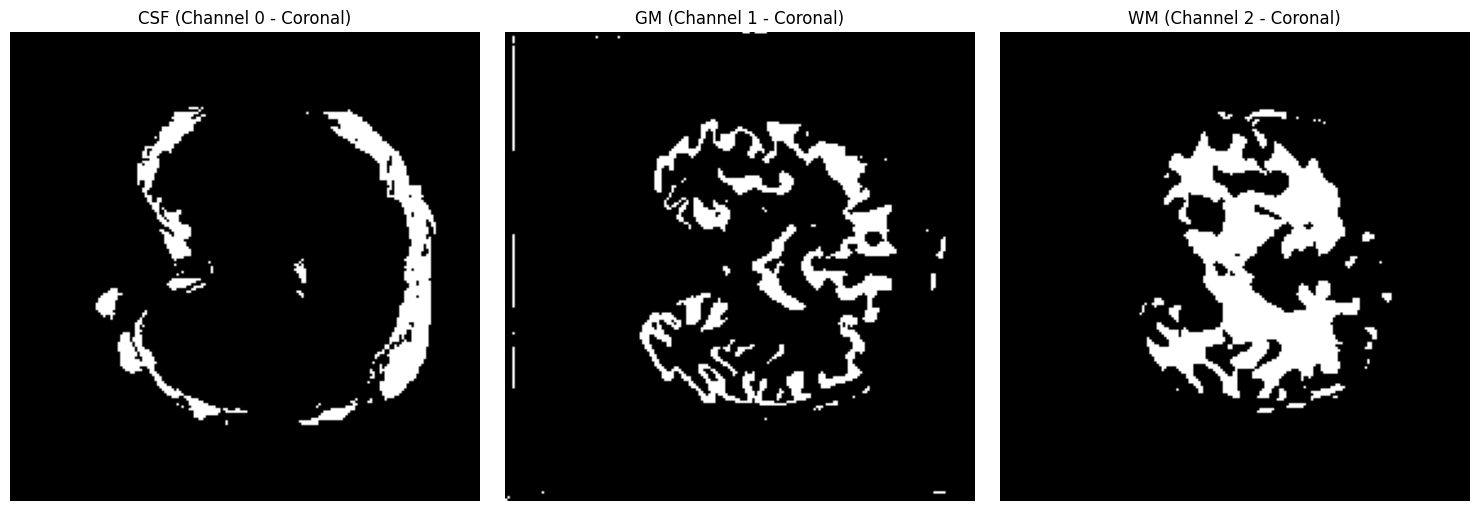

In [ ]:
# Threshold the channels
csf_thresh = csf > 0.6  # Threshold for CSF
gm_thresh = gm > 0.6    # Threshold for GM
wm_thresh = wm > 0.6    # Threshold for WM

# Choose a slice index for another axis (e.g., coronal)
slice_idx = 100 # Adjust as needed

# Plot the coronal view
plt.figure(figsize=(15, 5))

# CSF
plt.subplot(1, 3, 1)
plt.imshow(csf_thresh[:, slice_idx, :], cmap="gray")  # Coronal view (axis 1)
plt.title("CSF (Channel 0 - Coronal)")
plt.axis("off")

# GM
plt.subplot(1, 3, 2)
plt.imshow(gm_thresh[:, slice_idx, :], cmap="gray")  # Coronal view (axis 1)
plt.title("GM (Channel 1 - Coronal)")
plt.axis("off")

# WM
plt.subplot(1, 3, 3)
plt.imshow(wm_thresh[:, slice_idx, :], cmap="gray")  # Coronal view (axis 1)
plt.title("WM (Channel 2 - Coronal)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def add_background(pred_prob, gt):
    """
    Add background (label 0) from the ground truth to the predicted segmentation map.

    Args:
        pred_prob: Predicted probability map (C, H, W, D) where C is the number of classes (3: CSF, GM, WM).
        gt: Ground truth segmentation map (H, W, D) with 4 classes (0: background, 1: CSF, 2: GM, 3: WM).

    Returns:
        combined_segmentation: Segmentation map with background included (H, W, D).
    """
    # Convert predicted probabilities to a segmentation map (argmax)
    pred_segmentation = np.argmax(pred_prob, axis=0) + 1  # Shift to match labels 1, 2, 3

    # Create a background mask from the GT
    background_mask = (gt == 0)

    # Add background label to the predicted segmentation
    combined_segmentation = pred_segmentation.copy()
    combined_segmentation[background_mask] = 0  # Set background to 0 where GT is background

    return combined_segmentation

In [ ]:
# load the ground truth label map
gt = labels[0].numpy().squeeze()  # Remove batch dimension

# pred_prob: Model output (C, H, W, D)
# gt: Ground truth label map (H, W, D)
segmentation_with_background = add_background(pred_prob=output_np[0], gt=gt)

# Check the unique labels in the final segmentation
print(f"Unique labels in combined segmentation: {np.unique(segmentation_with_background)}")

Unique labels in combined segmentation: [0 1 2 3]


In [ ]:
# # Convert probability map to segmentation map
# segmentation_map = np.argmax(output_image, axis=0)  # Shape: (192, 192, 192)

# print(f"Segmentation map shape: {segmentation_map.shape}")

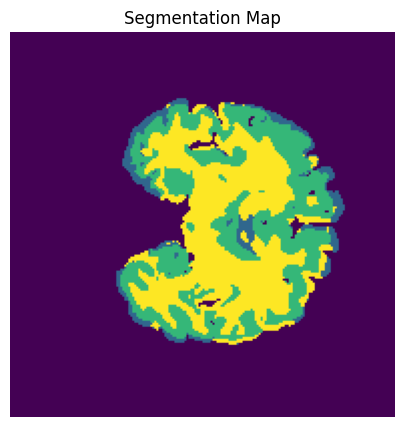

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(segmentation_with_background[:, slice_idx, :], cmap="viridis")
plt.title("Segmentation Map")
plt.axis("off")
plt.show()

In [ ]:
def compute_dice(pred, gt, num_classes=4):
    """
    Compute Dice coefficient for each class.

    Args:
        pred: Predicted segmentation map (H, W, D) with background (0) and foreground classes (1, 2, 3).
        gt: Ground truth segmentation map (H, W, D) with background (0) and foreground classes (1, 2, 3).
        num_classes: Total number of classes (including background).

    Returns:
        dice_scores: Dice coefficient for each foreground class (excluding background).
    """
    dice_scores = {}
    for label in range(1, num_classes):  # Exclude background (label 0)
        pred_binary = (pred == label)  # Binary mask for predicted label
        gt_binary = (gt == label)      # Binary mask for ground truth label

        intersection = np.sum(pred_binary & gt_binary)
        pred_sum = np.sum(pred_binary)
        gt_sum = np.sum(gt_binary)

        if pred_sum + gt_sum == 0:  # Avoid division by zero
            dice = 1.0  # Perfect score if both are empty
        else:
            dice = 2.0 * intersection / (pred_sum + gt_sum)

        dice_scores[f"Label {label}"] = dice  # Store Dice score for the class

    return dice_scores

# Example usage:
# segmentation_with_background: Combined segmentation map (H, W, D)
# ground_truth: Ground truth label map (H, W, D)

dice_scores = compute_dice(pred=segmentation_with_background, gt=gt)

# Print Dice scores for CSF, GM, WM
for label, dice in dice_scores.items():
    print(f"Dice for {label}: {dice:.4f}")


Dice for Label 1: 0.0540
Dice for Label 2: 0.6421
Dice for Label 3: 0.6901


In [ ]:
# Save CSF probability map
csf_nifti = nib.Nifti1Image(csf, affine=np.eye(4))
nib.save(csf_nifti, "csf_prob_map.nii.gz")

# Save segmentation map
seg_map_nifti = nib.Nifti1Image(segmentation_map.astype(np.uint8), affine=np.eye(4))
nib.save(seg_map_nifti, "segmentation_map.nii.gz")

print("Files saved: csf_prob_map.nii.gz and segmentation_map.nii.gz")

Files saved: csf_prob_map.nii.gz and segmentation_map.nii.gz


In [ ]:
def compute_mean_dice(dataloader, model, num_classes=4):
    """
    Compute mean Dice score for all samples in the dataloader.

    Args:
        dataloader: DataLoader object containing images and ground truth labels.
        model: Trained segmentation model.
        num_classes: Total number of classes (including background).

    Returns:
        mean_dice_scores: Mean Dice coefficient for each foreground class (excluding background).
    """
    model.eval()  # Set model to evaluation mode
    all_dice_scores = {f"Label {label}": [] for label in range(1, num_classes)}

    with torch.no_grad():
        for images, labels in dataloader:
            # Forward pass
            output = model(images)  # Output shape: (batch_size, num_classes-1, H, W, D)
            output_np = output.cpu().numpy()  # Convert to NumPy

            for batch_idx in range(images.size(0)):
                pred_prob = output_np[batch_idx]  # Predicted probabilities for the current sample
                gt = labels[batch_idx].numpy().squeeze()  # Ground truth for the current sample

                # Add background to the predicted segmentation
                segmentation_with_background = add_background(pred_prob=pred_prob, gt=gt)

                # Compute Dice scores for the current sample
                dice_scores = compute_dice(pred=segmentation_with_background, gt=gt, num_classes=num_classes)

                # Collect Dice scores for each label
                for label, dice in dice_scores.items():
                    all_dice_scores[label].append(dice)

    # Compute mean Dice scores for each class
    mean_dice_scores = {label: np.mean(scores) for label, scores in all_dice_scores.items()}
    return mean_dice_scores


In [ ]:
# Compute mean Dice scores
mean_dice_scores = compute_mean_dice(dataloader, model, num_classes=4)

# Print mean Dice scores for CSF, GM, WM
for label, mean_dice in mean_dice_scores.items():
    print(f"Mean Dice for {label}: {mean_dice:.4f}")

torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
torch.Size([1, 512, 12, 12, 12])
Mean Dice for Label 1: 0.0181
Mean Dice for Label 2: 0.6282
Mean Dice for Label 3: 0.6770
